# Music Style Transfer through LSTM

Here we are attempting to see whether we can transfer the style of the music by changing the notes themselves. Here, our definition of style transfer has changed. We are interested in seeing whether a network can generate music by being "inspired" from another music.

To do this, we will first train a CNN that classifies music well. Then, we will use the actiavtions from one of the layers as a feature extractor and extract features from music. 

Next step is to use the features we extracted to generate the music back. This is done by conditioning a (possibly bidirectional) LSTM using the feature vector, and then train it to generate the music that was used to extract the feature vector. We will train 2 such generators.

Last step is to see whether the generators works as a translator. We will take one music from one class and extract the features. And then feed the feature into the other class to generate music. We will see if the network picks up the styles and whether the network can be "inspired" by the music

In [1]:
import os
import mido
import keras
import numpy as np
import sklearn.model_selection as ms
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Loading data

Here we will load the data that was already preprocessed. We will do some final stitching to make it usable for our algorithms. One of the thing we realized is that the files are different sizes. So in order for CNN to work they must be the same size. So what we will do is just simply pad them with 0s so it will not affect training.

In [33]:
classical_matrices = np.load('matricies/classical_matrices.npy')
jazz_matrices = np.load('matricies/jazz_matrices.npy')
classical_infos = np.load('matricies/classical_infos.npy')
jazz_infos = np.load('matricies/jazz_infos.npy')

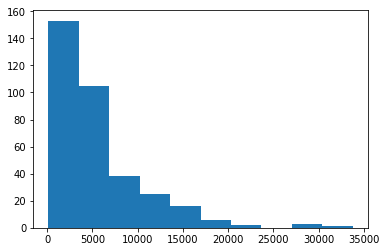

In [36]:
plt.hist([x.shape[0] for x in classical_matrices])
plt.show()

In [38]:
## Here we pad every array to be of size 33759
print(classical_matrices[0].shape)
for i in range(len(classical_matrices)):
    m = classical_matrices[i]
    if m.shape[0] > 6000:
        classical_matrices[i] = m[:6000, :, :]
    else:
        classical_matrices[i] = np.pad(m, ((0, 6000 - m.shape[0]), (0, 0), (0, 0)), 'constant', constant_values=(0,))

(10195, 130, 2)


In [39]:
for i in range(len(jazz_matrices)):
    m = jazz_matrices[i]
    if m.shape[0] > 6000:
        jazz_matrices[i] = m[:6000, :, :]
    else:
        jazz_matrices[i] = np.pad(m, ((0, 6000 - m.shape[0]), (0, 0), (0, 0)), 'constant', constant_values=(0,))

In [40]:
np.save('matricies/classical_matrices2.npy', classical_matrices)
np.save('matricies/jazz_matrices2.npy', jazz_matrices)

In [70]:
X1 = np.stack(classical_matrices)
X2 = np.stack(jazz_matrices)
X = np.concatenate((X1, X2), axis=0)
Y1 = np.ones(len(classical_matrices))
Y2 = np.zeros(len(jazz_matrices))
Y = np.concatenate((Y1, Y2))
Y = Y.reshape((-1, 1))

In [74]:
print(X.shape)
print(Y.shape)
np.save('matricies/newX.npy', X)
np.save('matricies/newY.npy', Y)

(698, 6000, 130, 2)
(698, 1)


In [67]:
print(X.shape)

(698, 6000, 130, 2)


In [75]:
X_train, X_test, Y_train, Y_test = ms.train_test_split(X, Y, test_size=0.2, random_state=43)
print X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

(558, 6000, 130, 2) (140, 6000, 130, 2) (558, 1) (140, 1)


## CNN encoding

In this section we first try to train a CNN that classifies music well. Here we will use a simple structure of

1. Conv
2. Dense
...


In [85]:
def model1(input_shape):
    X_input = keras.layers.Input(input_shape)
    X = keras.layers.Conv2D(filters=100, kernel_size=(10, 1), strides=(1, 1), padding='same', name='Conv0',
                            kernel_initializer=keras.initializers.glorot_normal(seed=None),
                            bias_initializer=keras.initializers.glorot_normal(seed=None),
                            data_format="channels_last")(X_input)
    X = keras.layers.BatchNormalization(axis = 3, name = 'bn0')(X)
    X = keras.layers.Activation('relu')(X)
    
    X = keras.layers.Conv2D(filters=50, kernel_size=(101, 1), strides=(1, 1), padding='same', name='Conv1',
                            kernel_initializer=keras.initializers.glorot_normal(seed=None),
                            bias_initializer=keras.initializers.glorot_normal(seed=None),
                            data_format="channels_last")(X_input)
    X = keras.layers.BatchNormalization(axis = 3, name = 'bn1')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(50, activation='sigmoid')(X)
    X = keras.layers.Dropout(0.5)(X)    
#     X = keras.layers.Dense(25, activation='sigmoid')(X)
#     X = keras.layers.Dropout(0.5)(X)    
    X = keras.layers.Dense(10, activation='sigmoid')(X)
    X = keras.layers.Dense(1, activation='sigmoid')(X)
    model = keras.models.Model(inputs=X_input, outputs=X, name='basic')
    return model

In [88]:
m = model1(X.shape[1:])
m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [ ]:
m.fit(X_train, Y_train, epochs=10)

Epoch 1/10


In [ ]:
def model(input_shape):
    X_inputs = keras.layers.Input(input_shape)
    X = X_inputs
    print(X.shape)
    X = keras.layers.Conv1D(filters=20, kernel_size=50, data_format="channels_last")(X)
    print(X.shape)
#     X = keras.layers.Dropout(0.5)(X)    
#     X = keras.layers.MaxPooling1D(pool_size=4)(X)
    X = keras.layers.BatchNormalization(axis = 2, name = 'bn0')(X)
    X = keras.layers.Activation('relu')(X)
    print(X.shape)
    
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(50, activation='sigmoid')(X)
#     X = keras.layers.Dropout(0.5)(X)    
    X = keras.layers.Dense(25, activation='sigmoid')(X)
#     X = keras.layers.Dropout(0.5)(X)    
    X = keras.layers.Dense(10, activation='sigmoid')(X)
    X = keras.layers.Dense(10, activation='softmax')(X)
    print(X.shape)
    
    model = keras.models.Model(inputs=X_inputs, outputs=X, name='cnn')
    return model

## LSTM 

Here we will train 2 (bidirectional) LSTMs. One for generating classical music and one for generating jazz music. The way we condition the LSTMs is to have a Dense layer that transforms our feature vectors into the shape of the cell state of the LSTM, and then we will use this cell state as the initial cell state of the LSTM, and train it to generate the original MIDI matrix. 